80134624/80134624 [==============================] - 1s 0us/step
Epoch 1/100
12/12 [==============================] - 79s 6s/step - loss: 0.6140 - accuracy: 0.7630 - val_loss: 0.5374 - val_accuracy: 0.9792
Epoch 2/100
12/12 [==============================] - 91s 8s/step - loss: 0.4983 - accuracy: 0.9766 - val_loss: 0.4553 - val_accuracy: 1.0000
Epoch 3/100
12/12 [==============================] - 73s 6s/step - loss: 0.4232 - accuracy: 0.9896 - val_loss: 0.3887 - val_accuracy: 1.0000
Epoch 4/100
12/12 [==============================] - 73s 6s/step - loss: 0.3620 - accuracy: 0.9922 - val_loss: 0.3336 - val_accuracy: 1.0000
Epoch 5/100
12/12 [==============================] - 72s 6s/step - loss: 0.3102 - accuracy: 0.9948 - val_loss: 0.2869 - val_accuracy: 1.0000
Epoch 6/100
12/12 [==============================] - 72s 6s/step - loss: 0.2671 - accuracy: 0.9974 - val_loss: 0.2459 - val_accuracy: 1.0000
Epoch 7/100
12/12 [==============================] - 70s 6s/step - loss: 0.2295 - accurac

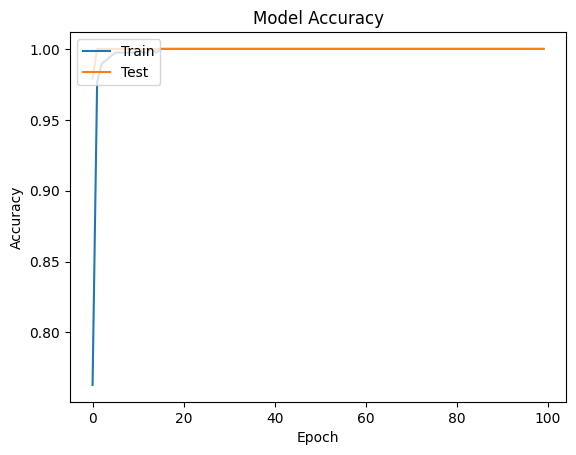

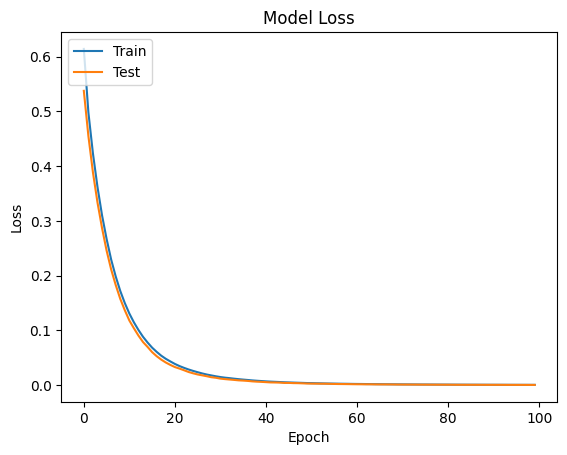

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import CSVLogger
import pandas as pd
from sklearn.metrics import roc_curve, auc

# Load data from positive and negative directories
def load_data_from_directories(pos_directory, neg_directory, img_size=(100, 100)):
    positive_images = []
    negative_images = []

    # Load positive images
    for filename in os.listdir(pos_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(pos_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize image
            positive_images.append(img)

    # Load negative images
    for filename in os.listdir(neg_directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(neg_directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)  # Resize image
            negative_images.append(img)

    return np.array(positive_images), np.array(negative_images)

# Directories containing positive and negative images
positive_directory = '/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/POSITIVE'
negative_directory = '/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/NEGATIVE'

# Load data
positive_images, negative_images = load_data_from_directories(positive_directory, negative_directory)

# Create labels
positive_labels = np.ones(len(positive_images))
negative_labels = np.zeros(len(negative_images))

# Combine images and labels
X = np.concatenate((positive_images, negative_images), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)

# Normalize pixel values
X = X / 255.0

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define VGG19 model
def create_vgg19_model(input_shape):
    base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create VGG19 model
input_shape = X_train[0].shape
vgg19_model = create_vgg19_model(input_shape)

# Compile the VGG19 model
vgg19_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Define file paths for logging
csv_logger_path = '/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_training_history.csv'
confusion_matrix_path = '/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_confusion_matrix.csv'
classification_report_path = '/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_PERFORMANCES_METRICS.csv'
roc_curve_path = '/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_roc_curve.png'

# Define CSVLogger callback
csv_logger = CSVLogger(csv_logger_path)

# Train the VGG19 model with 100 epochs and use the CSVLogger callback
vgg19_history = vgg19_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[csv_logger])

# Evaluate the VGG19 model
vgg19_test_loss, vgg19_test_accuracy = vgg19_model.evaluate(X_test, y_test)

print("VGG19 Test Loss:", vgg19_test_loss)
print("VGG19 Test Accuracy:", vgg19_test_accuracy)

# Generate predictions
vgg19_y_pred_probs = vgg19_model.predict(X_test)
vgg19_y_pred = (vgg19_y_pred_probs > 0.5).astype(int)

# Calculate accuracy
vgg19_accuracy = accuracy_score(y_test, vgg19_y_pred)
print("VGG19 Accuracy:", vgg19_accuracy)

# Calculate confusion matrix
vgg19_confusion_mat = confusion_matrix(y_test, vgg19_y_pred)
print("VGG19 Confusion Matrix:\n", vgg19_confusion_mat)

# Generate classification report
vgg19_class_report = classification_report(y_test, vgg19_y_pred)
print("VGG19 Classification Report:\n", vgg19_class_report)

# Convert confusion matrix to DataFrame
vgg19_confusion_df = pd.DataFrame(vgg19_confusion_mat, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

# Save confusion matrix to CSV
vgg19_confusion_df.to_csv(confusion_matrix_path)

# Convert classification report to DataFrame
vgg19_class_report_df = pd.DataFrame(classification_report(y_test, vgg19_y_pred, output_dict=True)).transpose()

# Save classification report to CSV
vgg19_class_report_df.to_csv(classification_report_path)

# Save the trained model
vgg19_model_save_path = '/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_model'
vgg19_model.save(vgg19_model_save_path)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, vgg19_y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot training history
plt.plot(vgg19_history.history['accuracy'])
plt.plot(vgg19_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot test loss
plt.plot(vgg19_history.history['loss'])
plt.plot(vgg19_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


Results, metrics, confusion matrix, and training history have been saved successfully.


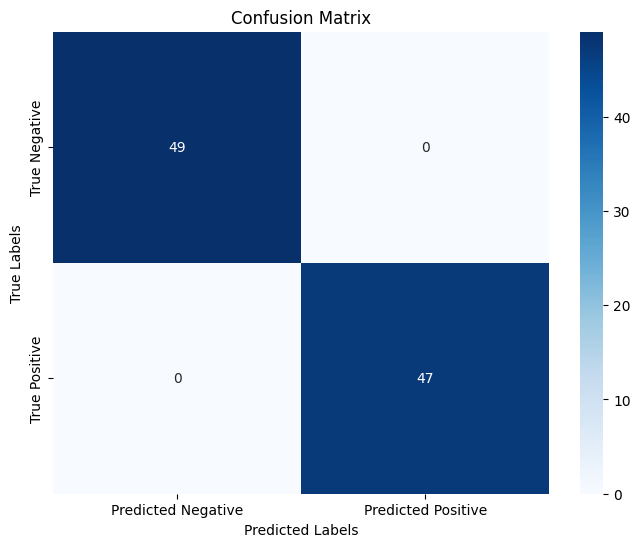

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the following variables from your model's evaluation:
# y_test, vgg19_y_pred, vgg19_test_loss, vgg19_test_accuracy, vgg19_history, vgg19_confusion_mat, vgg19_class_report

# Save the results to a CSV file
vgg19_results = pd.DataFrame({
    'True Labels': y_test,
    'Predicted Labels': vgg19_y_pred.flatten()  # Flatten predictions to match shape
})
vgg19_results.to_csv('/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_results.csv', index=False)

# Save the training history to a CSV file
history_df = pd.DataFrame(vgg19_history.history)
history_df.to_csv('/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_history1.csv', index=False)

# Save the performance metrics to a CSV file
metrics_df = pd.DataFrame({
    'Metric': ['Loss', 'Accuracy'],
    'Value': [vgg19_test_loss, vgg19_test_accuracy]
})
metrics_df.to_csv('/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_metrics.csv', index=False)

# Append confusion matrix and classification report to the results CSV file
with open('/content/drive/MyDrive/LABORATORY DATASET/LABORATORY DATASET (SEGREGATED)/VGG 19_RMSPROP_results.csv', 'a') as f:
    f.write('\n\n')  # Add a blank line
    f.write(f"VGG19 Test Loss:, {vgg19_test_loss}\n")
    f.write(f"VGG19 Test Accuracy:, {vgg19_test_accuracy}\n\n")

    f.write("VGG19 Confusion Matrix:\n")
    confusion_matrix_df = pd.DataFrame(vgg19_confusion_mat, columns=['Predicted Negative', 'Predicted Positive'], index=['True Negative', 'True Positive'])
    confusion_matrix_df.to_csv(f, index=True)

    f.write("\n\n")
    f.write("VGG19 Classification Report:\n")
    f.write(vgg19_class_report)

print("Results, metrics, confusion matrix, and training history have been saved successfully.")

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(vgg19_confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
